# ML - Intrusion Detection System

Intrusion detection is a crucial component of modern cybersecurity, helping organizations identify unauthorized access and mitigate security risks in real-time. This project will use the NSL-KDD dataset to analyze network traffic data for intrusion detection, exploring patterns in normal versus malicious activity and identifying effective ways to classify different types of attacks.

# Stage 1

## Import Librairies

We import the needed librairies

In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder,KBinsDiscretizer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import StackingClassifier
from scipy.stats import randint


## Analyse Data

Our Kaggle dataset is already separated in train and test, we need to rebuild it.

In [2]:
df = pd.concat([pd.DataFrame(arff.loadarff('Datatsets\Original_Test.arff')[0]),pd.DataFrame(arff.loadarff('Datatsets\Original_Train.arff')[0])])
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,b'tcp',b'private',b'REJ',0.0,0.0,b'0',0.0,0.0,0.0,...,10.0,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,b'anomaly'
1,0.0,b'tcp',b'private',b'REJ',0.0,0.0,b'0',0.0,0.0,0.0,...,1.0,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,b'anomaly'
2,2.0,b'tcp',b'ftp_data',b'SF',12983.0,0.0,b'0',0.0,0.0,0.0,...,86.0,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,b'normal'
3,0.0,b'icmp',b'eco_i',b'SF',20.0,0.0,b'0',0.0,0.0,0.0,...,57.0,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,b'anomaly'
4,1.0,b'tcp',b'telnet',b'RSTO',0.0,15.0,b'0',0.0,0.0,0.0,...,86.0,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,b'anomaly'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.0,b'tcp',b'private',b'S0',0.0,0.0,b'0',0.0,0.0,0.0,...,25.0,0.10,0.06,0.00,0.00,1.00,1.0,0.00,0.00,b'anomaly'
125969,8.0,b'udp',b'private',b'SF',105.0,145.0,b'0',0.0,0.0,0.0,...,244.0,0.96,0.01,0.01,0.00,0.00,0.0,0.00,0.00,b'normal'
125970,0.0,b'tcp',b'smtp',b'SF',2231.0,384.0,b'0',0.0,0.0,0.0,...,30.0,0.12,0.06,0.00,0.00,0.72,0.0,0.01,0.00,b'normal'
125971,0.0,b'tcp',b'klogin',b'S0',0.0,0.0,b'0',0.0,0.0,0.0,...,8.0,0.03,0.05,0.00,0.00,1.00,1.0,0.00,0.00,b'anomaly'


### Missing values


There is no missing values

In [3]:
print(df.isnull().sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

### Outliers

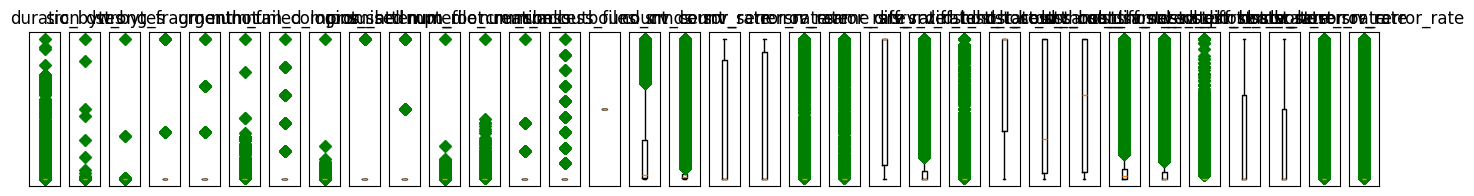

In [4]:
# IQR : 
# Les observations qui sont à plus de 1,5 IQR en dessous de Q1 ou à plus de 1,5 IQR au-dessus de Q3 sont considérées comme des valeurs aberrantes.
def find_outliers_IQR(col):
    q1=col.quantile(0.25)
    q3=col.quantile(0.75)
    IQR=q3-q1
    outliers = col[((col<(q1-1.5*IQR)) | (col>(q3+1.5*IQR)))]
    # return list of outliers
    return outliers

def dropOutliers(df):

    df_cleaned = df.copy()
    
    for col in df_cleaned.columns:
        if df_cleaned[col].dtype in ['float64', 'int64']:
            outliers = find_outliers_IQR(df_cleaned[col])
            df_cleaned = df_cleaned.drop(outliers.index)
    return df_cleaned

def boxplotOutliers(df):
    nb_columns = len(df.select_dtypes(include=["int64", "float64"]).columns)
    fig, axs = plt.subplots(1, nb_columns, figsize=(15,2))
    for i in range(nb_columns):
            column_name = df.select_dtypes(include=["int64", "float64"]).columns[i]
            axs[i].boxplot(df[column_name], 0, 'gD')
            axs[i].set_title(column_name)
            axs[i].set_xticks(())
            axs[i].set_yticks(())
    fig.subplots_adjust(left=0.08, right=0.98, hspace=0.4, wspace=0.3)

boxplotOutliers(df)

There are a lot of columns with an outstanding number of outliers. It could be interesting to drop the columns filled with unique values.

### Statistical summary

In [5]:
print(df.describe())

            duration     src_bytes     dst_bytes  wrong_fragment  \
count  148517.000000  1.485170e+05  1.485170e+05   148517.000000   
mean      276.779305  4.022795e+04  1.708885e+04        0.020523   
std      2460.683131  5.409612e+06  3.703525e+06        0.240069   
min         0.000000  0.000000e+00  0.000000e+00        0.000000   
25%         0.000000  0.000000e+00  0.000000e+00        0.000000   
50%         0.000000  4.400000e+01  0.000000e+00        0.000000   
75%         0.000000  2.780000e+02  5.710000e+02        0.000000   
max     57715.000000  1.379964e+09  1.309937e+09        3.000000   

              urgent            hot  num_failed_logins  num_compromised  \
count  148517.000000  148517.000000      148517.000000    148517.000000   
mean        0.000202       0.189379           0.004323         0.255062   
std         0.019417       2.013160           0.072248        22.231375   
min         0.000000       0.000000           0.000000         0.000000   
25%         

### Variable Definition

In [6]:
print(df.dtypes)

duration                       float64
protocol_type                   object
service                         object
flag                            object
src_bytes                      float64
dst_bytes                      float64
land                            object
wrong_fragment                 float64
urgent                         float64
hot                            float64
num_failed_logins              float64
logged_in                       object
num_compromised                float64
root_shell                     float64
su_attempted                   float64
num_root                       float64
num_file_creations             float64
num_shells                     float64
num_access_files               float64
num_outbound_cmds              float64
is_host_login                   object
is_guest_login                  object
count                          float64
srv_count                      float64
serror_rate                    float64
srv_serror_rate          

We have some object column. We will have to apply label-encoding.

Our target column will be class, normal or anomaly 

### Check balance

In [7]:
print(df['class'].value_counts())

class
b'normal'     77054
b'anomaly'    71463
Name: count, dtype: int64


Our target column is pretty well balanced

### Correlation analysis (for numerical variables)

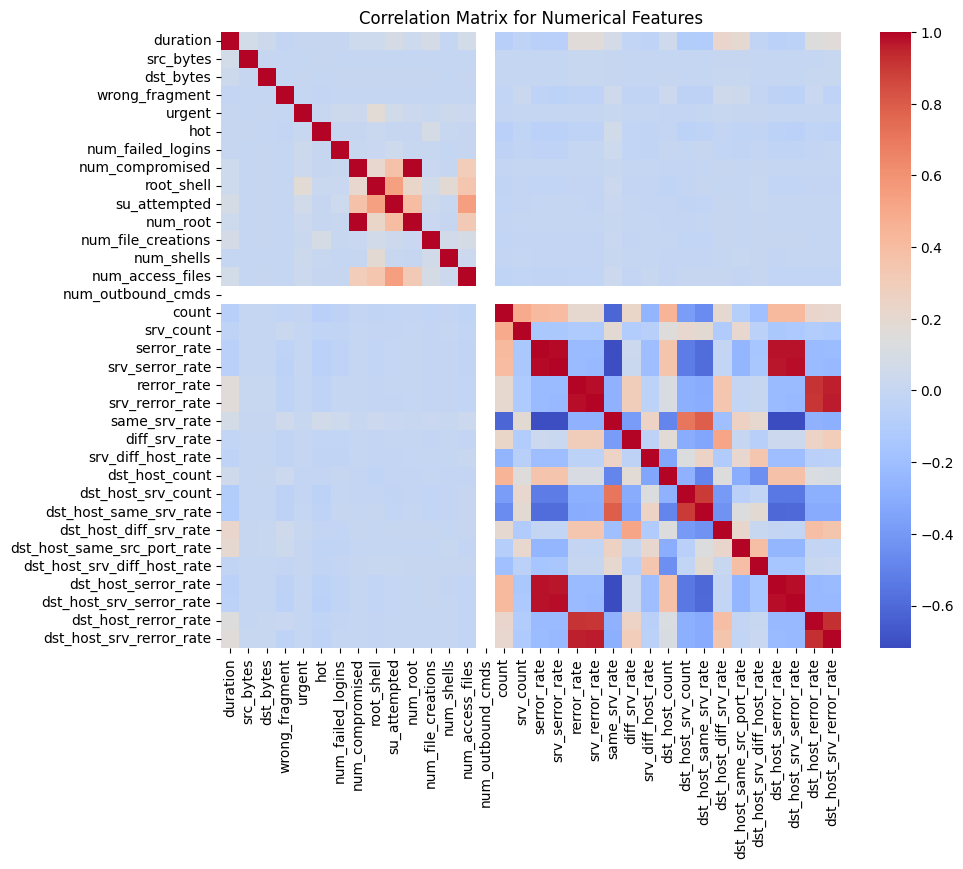

In [8]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Matrix for Numerical Features")
plt.show()

## Implement Solutions for Each Task

### Pre-processing

In [9]:
def label_encode(df, columns=None):
    # If no columns are specified, select categorical columns by default
    if columns is None:
        columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Apply label encoding to each specified column
    for col in columns:
        df[col] = label_encoder.fit_transform(df[col])

    return df

# Example usage:
df = label_encode(df)

# Check the result
print(df.head())

   duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0       0.0              1       49     1        0.0        0.0     0   
1       0.0              1       49     1        0.0        0.0     0   
2       2.0              1       20     9    12983.0        0.0     0   
3       0.0              0       14     9       20.0        0.0     0   
4       1.0              1       60     2        0.0       15.0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0             0.0     0.0  0.0  ...                10.0   
1             0.0     0.0  0.0  ...                 1.0   
2             0.0     0.0  0.0  ...                86.0   
3             0.0     0.0  0.0  ...                57.0   
4             0.0     0.0  0.0  ...                86.0   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61                    0.

### Choose the right algorithms

We are in a classification problem, we'll use Logistic Regression and Random Forest. However, we might strugle if our data is too non-linear for the Logistic Regression to perform.

### Logistic Regression

In [10]:
# Create a pipeline for Logistic Regression
pipeline_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('model', LogisticRegression(max_iter=500,random_state=42))  # Logistic Regression model
])

### Random Forest

In [ ]:
# Create a pipeline for Random Forest
pipeline_rf = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('model', RandomForestClassifier(criterion="entropy", n_estimators=10,max_depth=4, random_state=42))  # Random Forest model
])

## Learning and Testing

### Train and test datasets

In [12]:

Y = df['class']
X = df.drop('class', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Train models

In [13]:
# Fit the Logistic Regression model
pipeline_lr.fit(X_train, Y_train)

# Fit the Random Forest model
pipeline_rf.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=4,
                                        n_estimators=10, random_state=1))])

### Predictions

In [14]:
# Make predictions for Logistic Regression
Y_pred_lr = pipeline_lr.predict(X_test)

# Make predictions for Random Forest
Y_pred_rf = pipeline_rf.predict(X_test)

## Critics

### For Logistic Regression

In [15]:
accuracy = accuracy_score(Y_test, Y_pred_lr)
confusion = confusion_matrix(Y_test, Y_pred_lr)
classification_rep = classification_report(Y_test,Y_pred_lr)

print(accuracy)
print(classification_rep)
print(confusion)

0.9372811742526259
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     14158
           1       0.93      0.96      0.94     15546

    accuracy                           0.94     29704
   macro avg       0.94      0.94      0.94     29704
weighted avg       0.94      0.94      0.94     29704

[[12973  1185]
 [  678 14868]]


### For Random Forest

In [16]:
accuracy = accuracy_score(Y_test, Y_pred_rf)
confusion = confusion_matrix(Y_test, Y_pred_rf)
classification_rep = classification_report(Y_test,Y_pred_rf)

print(accuracy)
print(classification_rep)
print(confusion)

0.9628332884460006
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     14158
           1       0.94      0.99      0.97     15546

    accuracy                           0.96     29704
   macro avg       0.97      0.96      0.96     29704
weighted avg       0.96      0.96      0.96     29704

[[13209   949]
 [  155 15391]]


In both cases the metrics are very good, we might be in a case of overfitting. 

We have many columns so using PCA, drop useless columns or more complex alogrithmds are good leads. 

# Stage 2

## Outliers and dimension reduction

### Unrelevant columns

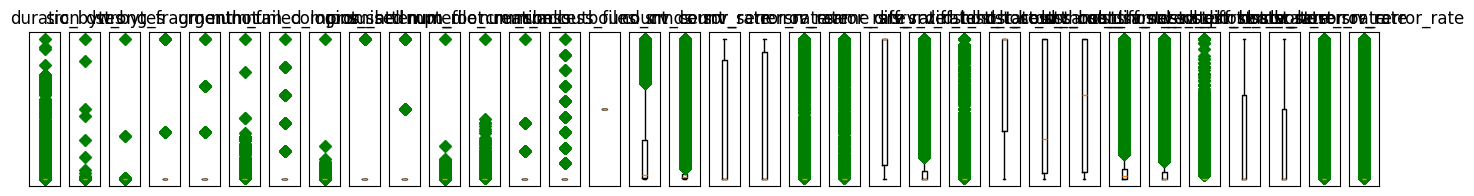

In [17]:
boxplotOutliers(df)

On the boxplot we can see that a lot of columns are filled with outliers. We can't drop them or we wouls lose too much rows.

In [18]:
for col in df.columns:
    print(df[col].value_counts())

duration
0.0        134973
1.0          2576
2.0           946
4.0           890
3.0           677
            ...  
18632.0         1
12653.0         1
36204.0         1
4106.0          1
679.0           1
Name: count, Length: 3424, dtype: int64
protocol_type
1    121569
2     17614
0      9334
Name: count, dtype: int64
service
24    48191
49    26627
12     9937
54     8247
20     7711
      ...  
61        4
27        2
3         2
22        2
25        1
Name: count, Length: 70, dtype: int64
flag
9     89820
5     36864
1     15083
4      3090
2      2335
6       386
10      344
8       298
7       142
3       105
0        50
Name: count, dtype: int64
src_bytes
0.0        57018
8.0         3744
1.0         2905
44.0        2647
45.0        2317
           ...  
70144.0        1
81920.0        1
2605.0         1
11772.0        1
2358.0         1
Name: count, Length: 3601, dtype: int64
dst_bytes
0.0         77333
105.0        1550
44.0         1330
8314.0       1207
93.0          729

In [19]:
df = df.drop(columns=['num_outbound_cmds'])

We observe the column `num_outbond_cmds` have the same value each row. We decide to drop it.

Other columns seems to have a very low variance. To determine those unrelevant to our problem we calcul the variance of each column.

In [20]:
print(df.var())         #Get columns variance
low_variance_cols = [col for col in df.columns if df[col].var() < 0.1]      # Select columns with variance under 0.1
print(low_variance_cols)

duration                       6.054961e+06
protocol_type                  1.783402e-01
service                        2.654128e+02
flag                           7.700354e+00
src_bytes                      2.926390e+13
dst_bytes                      1.371610e+13
land                           2.154186e-04
wrong_fragment                 5.763316e-02
urgent                         3.770229e-04
hot                            4.052813e+00
num_failed_logins              5.219807e-03
logged_in                      2.405516e-01
num_compromised                4.942340e+02
root_shell                     1.505980e-03
su_attempted                   1.796833e-03
num_root                       5.147918e+02
num_file_creations             2.681822e-01
num_shells                     7.673182e-04
num_access_files               9.073825e-03
is_host_login                  8.079285e-05
is_guest_login                 1.215694e-02
count                          1.363307e+04
srv_count                      5

To ensure we don't drop valuable columns we also check the correlation of each column with our target.

In [21]:
X = df.drop(columns=['class'])  # Features
y = df['class']  # Target

mi_scores = mutual_info_classif(X, y)   #We search for the information gain

# Results
mi_results = pd.DataFrame({
    'Feature': X.columns,
    'Information Gain (MI Score)': mi_scores
})

# We sort the results for display
print(mi_results.sort_values(by='Information Gain (MI Score)', ascending=False))

# Select features with gain inferior to 0.1
low_info_columns = mi_results[mi_results['Information Gain (MI Score)'] < 0.1]['Feature'].values
print(low_info_columns)

                        Feature  Information Gain (MI Score)
4                     src_bytes                     0.544003
5                     dst_bytes                     0.437474
2                       service                     0.434210
3                          flag                     0.338695
27                same_srv_rate                     0.328730
28                diff_srv_rate                     0.320607
31           dst_host_srv_count                     0.302559
32       dst_host_same_srv_rate                     0.278408
11                    logged_in                     0.262780
33       dst_host_diff_srv_rate                     0.257491
36         dst_host_serror_rate                     0.238721
23                  serror_rate                     0.236638
21                        count                     0.234176
37     dst_host_srv_serror_rate                     0.232251
24              srv_serror_rate                     0.221919
35  dst_host_srv_diff_ho

We now drop features with both low variance and both info gain.

In [22]:
columns_to_drop = list(set(low_variance_cols).intersection(set(low_info_columns)))
df = df.drop(columns=columns_to_drop)
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,hot,logged_in,num_compromised,num_root,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,1,49,1,0.0,0.0,0.0,0,0.0,0.0,...,10.0,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,0
1,0.0,1,49,1,0.0,0.0,0.0,0,0.0,0.0,...,1.0,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,0
2,2.0,1,20,9,12983.0,0.0,0.0,0,0.0,0.0,...,86.0,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,1
3,0.0,0,14,9,20.0,0.0,0.0,0,0.0,0.0,...,57.0,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,0
4,1.0,1,60,2,0.0,15.0,0.0,0,0.0,0.0,...,86.0,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.0,1,49,5,0.0,0.0,0.0,0,0.0,0.0,...,25.0,0.10,0.06,0.00,0.00,1.00,1.0,0.00,0.00,0
125969,8.0,2,49,9,105.0,145.0,0.0,0,0.0,0.0,...,244.0,0.96,0.01,0.01,0.00,0.00,0.0,0.00,0.00,1
125970,0.0,1,54,9,2231.0,384.0,0.0,1,0.0,0.0,...,30.0,0.12,0.06,0.00,0.00,0.72,0.0,0.01,0.00,1
125971,0.0,1,30,5,0.0,0.0,0.0,0,0.0,0.0,...,8.0,0.03,0.05,0.00,0.00,1.00,1.0,0.00,0.00,0


### PCA and RFE

First we'll add PCA to our pipelines. PCA will help us reduce dimensionality by creating new features. The downsides are that it redeuces the interpretability as new features don't have any meaning and it doesn't take in account the target.

### Logistic Regression

In [23]:
# Create a pipeline for Logistic Regression with PCA
pipeline_lr_PCA = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('pca', PCA()),                # Apply PCA
    ('model', LogisticRegression(max_iter=500,random_state=42))  # Logistic Regression model
])

### Random Forest

In [ ]:
# Create a pipeline for Random Forest with PCA
pipeline_rf_PCA = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('pca', PCA()),                # Apply PCA
    ('model', RandomForestClassifier(criterion="entropy", n_estimators=10,max_depth=4, random_state=42))  # Random Forest model
])

In the other hand we'll also try dimension reduction with RFE. It's not really a dimensional reduction as we only remove features but it's done with the target and it doesn't reduce interpretability.

### Logistic Regression

In [25]:
# Create a pipeline for Logistic Regression with RFE
pipeline_lr_RFE = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('rfe', RFE(estimator=RandomForestClassifier(), n_features_to_select=15)),  # Step 2: Apply RFE
    ('model', LogisticRegression(max_iter=500,random_state=42))  # Logistic Regression model
])

### Random Forest

In [ ]:
# Create a pipeline for Random Forest with RFE
pipeline_rf_RFE = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('rfe', RFE(estimator=RandomForestClassifier(), n_features_to_select=15)),  # Step 2: Apply RFE
    ('model', RandomForestClassifier(criterion="entropy", n_estimators=10,max_depth=4, random_state=42))  # Random Forest model
])

## Grid sreach and hyperparameter tunning

In [27]:
# Split the dataset
X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initial model
rf_model = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=2, n_estimators=100)

# Cross-validation scores for default RandomForest
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=3, scoring='accuracy')  # Reduced to 3 folds
print("Cross-validation scores (default model):", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print("Standard deviation of CV accuracy:", cv_scores.std())

# Define a smaller parameter grid for faster GridSearchCV
param_grid = {
    'n_estimators': [75,100,125,150],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 3],
    'bootstrap': [True, False]
}

# GridSearchCV with fewer folds (cv=3) and parallel processing (n_jobs=-1)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters and CV accuracy from GridSearchCV
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best cross-validated accuracy from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model from GridSearchCV on the test set
best_rf_model_grid = grid_search.best_estimator_
y_pred_grid = best_rf_model_grid.predict(X_test)
print("Test accuracy (GridSearchCV):", accuracy_score(y_test, y_pred_grid))
print("Classification Report (GridSearchCV):")
print(classification_report(y_test, y_pred_grid))

# --- Now apply RandomizedSearchCV ---

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# RandomizedSearchCV with fewer iterations (n_iter=50) for faster results
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=50, cv=3, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best hyperparameters and CV accuracy from RandomizedSearchCV
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)
print("Best cross-validated accuracy from RandomizedSearchCV:", random_search.best_score_)

# Evaluate the best model from RandomizedSearchCV on the test set
best_rf_model_random = random_search.best_estimator_
y_pred_random = best_rf_model_random.predict(X_test)
print("Test accuracy (RandomizedSearchCV):", accuracy_score(y_test, y_pred_random))
print("Classification Report (RandomizedSearchCV):")
print(classification_report(y_test, y_pred_random))

Cross-validation scores (default model): [0.9918047  0.99284354 0.99307419]
Mean CV accuracy: 0.9925741431887873
Standard deviation of CV accuracy: 0.0005521683672909453
Best Parameters from GridSearchCV: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Best cross-validated accuracy from GridSearchCV: 0.9957387919325782
Test accuracy (GridSearchCV): 0.9964314570428225
Classification Report (GridSearchCV):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     21328
           1       1.00      1.00      1.00     23228

    accuracy                           1.00     44556
   macro avg       1.00      1.00      1.00     44556
weighted avg       1.00      1.00      1.00     44556

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters from RandomizedSearchCV: {'bootstrap': False, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 138

We make new pipelines with the new parameters found by randomized search.

In [ ]:
# Create a pipeline for Logistic Regression with PCA
pipeline_lr_PCA = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('pca', PCA()),                # Apply PCA
    ('model', LogisticRegression(max_iter=500,random_state=42))  # Logistic Regression model
])

# Create a pipeline for Random Forest with PCA
pipeline_rf_PCA = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('pca', PCA()),                # Apply PCA
    ('model', RandomForestClassifier(criterion="entropy",bootstrap="false", min_samples_leaf=1,min_samples_split=5,n_estimators=138,max_depth=50, random_state=42))  # Random Forest model
])

# Create a pipeline for Logistic Regression with RFE
pipeline_lr_RFE = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('rfe', RFE(estimator=RandomForestClassifier(), n_features_to_select=15)),  # Step 2: Apply RFE
    ('model', LogisticRegression(max_iter=500,random_state=42))  # Logistic Regression model
])

# Create a pipeline for Random Forest with RFE
pipeline_rf_RFE = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('rfe', RFE(estimator=RandomForestClassifier(), n_features_to_select=15)),  # Step 2: Apply RFE
    ('model', RandomForestClassifier(criterion="entropy",bootstrap="false", min_samples_leaf=1,min_samples_split=5,n_estimators=138,max_depth=50, random_state=42))  # Random Forest model
])

## Ensemble Learning

We need to choose an ensemble learning method. As we have a two different models, a medium dataset and rather good computational ressources we use Stacking.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

meta_model = LogisticRegression(max_iter=1000, random_state=42)

# Create the Stacking Classifier with pipelines
stacking_clf = StackingClassifier(
    estimators=[
        ('logreg_pipeline', pipeline_lr_RFE),
        ('rf_pipeline', pipeline_rf_RFE)
    ],
    final_estimator=meta_model,  # Meta-model
    cv=5,                        # Cross-validation for stacking
    n_jobs=-1                    # Parallel processing
)

# Train the Stacking Classifier
stacking_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Classifier with Pipelines Accuracy: {accuracy:.2f}")

Stacking Classifier with Pipelines Accuracy: 0.95
